In [2]:
from __future__ import unicode_literals, print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch.utils import data
import os
from os import listdir
from os.path import join, abspath
import itertools
import re
import random
import time
from torch.autograd import Variable
from scipy.signal import tukey
from torch.utils import data
from tqdm.notebook import tqdm
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import warnings
warnings.filterwarnings("ignore")

IMG_DIR = '/home/eliza/mlhc/imgs'
DIR = abspath('RT_Cases_NU_HRPCI')
PREPROCESS_DIR = abspath('../data/data')
CONTINOUS_DIR = join(PREPROCESS_DIR, 'continuous')
WINDOW_SIZE = 15000
STEP_SIZE = 250
MIN_VALID_AOP = 50
MAX_VALID_AOP = 200
SLICES_DIR = join(PREPROCESS_DIR, 'slices')

In [3]:
device

device(type='cpu')

In [4]:
def scale_data(data_x, data_y, out_pos = 0, return_current_avg_std = False):
    """ 
    Arg:
        data_x: features
        data_y: labels
        out_pos: the position of feature of which average and stand deviation will be returned.
    returns:
        1. Normalized features and labels
        2. Average and standard deviation of the selected feature.
    """
    avg = data_x[:,:,out_pos].mean()
    std = data_x[:,:,out_pos].std()
    c_avg = data_x[:,:,1].mean()
    c_std = data_x[:,:,1].std()
    for i in range(data_x.shape[-1]):
        data_x[:,:,i] = (data_x[:,:,i] - data_x[:,:,i].mean())/data_x[:,:,i].std()
    data_y = (data_y-avg)/std
    if return_current_avg_std:
        return data_x, data_y, (avg, std), (c_avg, c_std)   
    else:
        return data_x, data_y, (avg, std)

class Dataset(data.Dataset):
    def __init__(self, X, Y, lst_index, output_steps, position_embedding = (False)):
        """
        Args:
            lst_index: indexes of observations in the dataset.
            output_steps: Forecasting Horizon.
        """
        self.X = X[lst_index]
        self.Y = Y[lst_index]
        self.output_steps = output_steps
        
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        x = self.X[index]
        y = self.Y[index][:self.output_steps]
        return x, y

In [5]:
TREND = 'ids' # id, is, ds
X_train = torch.load(os.path.abspath('/content/sample_data/seq2seq/at_train/%s_x_train' % TREND))
Y_train = torch.load(os.path.abspath('/content/sample_data/seq2seq/at_train/%s_y_train' % TREND))
sample_size, pred_length, feature_count = X_train.shape

TEST_TREND = 'ids'
X_test = torch.load(os.path.abspath('/content/sample_data/seq2seq/at_test/%s_x_test' % TEST_TREND))
Y_test = torch.load(os.path.abspath('/content/sample_data/seq2seq/at_test/%s_y_test' % TEST_TREND))
test_input_size = X_test.shape[0]

TUNING = False  
test_size = 1000 if TUNING else min(sample_size // 4 * 1, test_input_size)
train_valid_size = test_size * 4
training_size = test_size * 3
validation_size = test_size * 1
print('Total: %d\nTraining: %d, Validation: %d, Test: %d' % (train_valid_size, training_size, validation_size, test_size))
print('Test set: %d ~ %d'% (test_input_size-test_size, test_input_size))

X_all = torch.cat([X_train[:train_valid_size], X_test[test_input_size-test_size: test_input_size]])
Y_all = torch.cat([Y_train[:train_valid_size], Y_test[test_input_size-test_size: test_input_size]])
X, Y, (avg, std), (c_avg, c_std) = scale_data(X_all, Y_all, out_pos = 0, return_current_avg_std = True)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\content\\sample_data\\seq2seq\\at_train\\ids_x_train'

In [1]:
print(test_size, train_valid_size, training_size, validation_size)

NameError: name 'test_size' is not defined

In [11]:
X_train.shape

torch.Size([18000, 30, 2])

In [12]:
X_test.shape

torch.Size([4500, 30, 2])

In [13]:
X_all.shape

torch.Size([22500, 30, 2])

In [14]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            input_dim: the dimension of input sequences.
            hidden_dim: number hidden units.
            num_layers: number of encode layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Encoder, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, 
                            bidirectional = True, dropout = dropout_rate, batch_first = True)
        
    def forward(self, source):
        """
        Args:
            source: input tensor(batch_size*input dimension)
        Return:
            outputs: Prediction
            concat_hidden: hidden states
        """
        outputs, hidden = self.lstm(source)
        return outputs, hidden
    
class Decoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, num_layers, dropout_rate):
        """
        Args:
            output_dim: the dimension of output sequences.
            hidden_dim: number hidden units.
            num_layers: number of code layers.
            dropout_rate: recurrent dropout rate.
        """
        super(Decoder, self).__init__()
        
        # Since the encoder is bidirectional, decoder has double hidden size
        self.lstm = nn.LSTM(output_dim, hidden_dim*2, num_layers = num_layers, 
                            dropout = dropout_rate, batch_first = True)
        
        self.out = nn.Linear(hidden_dim*2, output_dim)
      
    def forward(self, x, hidden):
        """
        Args:
            x: prediction from previous prediction.
            hidden: hidden states from previous cell.
        Returns:
            1. prediction for current step.
            2. hidden state pass to next cell.
        """
        output, hidden = self.lstm(x, hidden)   
        prediction = self.out(output.float())
        return prediction, hidden     
    
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        """
        Args:
            encoder: Encoder object.
            decoder: Decoder object.
            device: 
        """
        super(Seq2Seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device

    def forward(self, source, target_tensor):
        """
        Args:
            source: input tensor.
            target_length: forecasting steps.
        Returns:
            total prediction
        """
        batch_size = source.size(0) 
        input_length = source.size(1) 
        target_length = target_tensor.shape[1]
        output_dim = target_tensor.shape[-1]
        encoder_hidden = (torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device),
                          torch.zeros(self.encoder.num_layers*2, batch_size, self.encoder.hidden_dim, device=device))
        encoder_output, encoder_hidden = self.encoder(source)
        
        # Concatenate the hidden states of both directions.
        num_layers = int(encoder_hidden[0].shape[0]/2)
        h = torch.cat([encoder_hidden[0][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[0][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        c = torch.cat([encoder_hidden[1][0:self.encoder.num_layers,:,:], 
                       encoder_hidden[1][-self.encoder.num_layers:,:,:]], 
                      dim=2, out=None).to(device)
        concat_hidden = (h, c)
        
        
        outputs = torch.zeros(batch_size, target_length, output_dim).to(self.device)
        decoder_output = torch.zeros((batch_size, 1, output_dim), device = self.device)
        decoder_hidden = concat_hidden
        
        for t in range(target_length):  
            decoder_output, decoder_hidden = self.decoder(decoder_output, decoder_hidden)
            outputs[:,t:t+1,:] = decoder_output
        return outputs

In [15]:
def run_epoch_train(model, data_generator, model_optimizer, criterion):
    """
    Args:
        model: RNN model.
        data_generator: data.DataLoader object.
        model_optimizer: optimizer.
        criterion: loss function
    Returns:
        Root Mean Square Error on Training Dataset
    """
    MSE = []
    for x, y in data_generator:
        # The input shape for nn.conv1d should sequence_length * batch_size * #features
        input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
        model_optimizer.zero_grad()
        loss = 0
        output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
        num_iter = output.size(0)
        for ot in range(num_iter):
            loss += criterion(output[ot], target_tensor[ot])
        MSE.append(loss.item()/num_iter)
        loss.backward()
        model_optimizer.step()
    
    return round(np.sqrt(np.mean(MSE)), 5)
 

def run_epoch_eval(model, data_generator, criterion, return_pred = False):
    """
    Args:
        model: CNN model.
        data_generator: data.DataLoader object.
        criterion: loss function
    Returns:
        Root Mean Square Error on evaluation datasets.
    """
    with torch.no_grad():
        MSE = []
        preds = []
        for x, y in data_generator:
            input_tensor, target_tensor = x.to(device).float(), y.to(device).float()
            loss = 0
            output = model(input_tensor, target_tensor).reshape(target_tensor.shape)
            preds.append(output.cpu().detach().numpy())
            num_iter = output.size(0)
            
            for ot in range(num_iter):
                loss += criterion(output[ot], target_tensor[ot])
            MSE.append(loss.item()/num_iter)
            
    if return_pred == True:
        preds =  np.concatenate(preds).squeeze(-1)
        return round(np.sqrt(np.mean(MSE)), 5), preds
    else:
        return round(np.sqrt(np.mean(MSE)), 5)


def train_model(model, X, Y, learning_rate, output_steps, batch_size, train_idx, valid_idx, test_idx, test=False, return_pred=False):
    # Initialize the model and define optimizer, learning rate decay and criterion
    optimizer = torch.optim.RMSprop(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size= 5, gamma=0.8)
    criterion = nn.MSELoss()
    
    # Split dataset into training set, validation set and test set.
    train_rmse, train_set = [], Dataset(X, Y, train_idx, output_steps)
    valid_rmse, valid_set = [], Dataset(X, Y, valid_idx, output_steps)
    if test:
        test_rmse, test_set = [], Dataset(X, Y, test_idx, output_steps)
    
    min_loss = 1000
    best_model = 0
    best_preds = 0
    min_valid_loss = 1000
    
    for i in tqdm(range(200)):
        start = time.time()
        scheduler.step()
        train_generator = data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
        valid_generator = data.DataLoader(valid_set, batch_size = batch_size, shuffle = False)
        if test:
            test_generator = data.DataLoader(test_set, batch_size = batch_size, shuffle = False)
 
        model.train()
        train_rmse.append(run_epoch_train(model, train_generator, optimizer, criterion))
            
        model.eval()
        rmse, predictions = run_epoch_eval(model,  valid_generator, criterion, return_pred = True)
        valid_rmse.append(rmse)
        
        if test:
            if return_pred:
                t_rmse, test_predictions = run_epoch_eval(model, test_generator, criterion, return_pred = True)
            else:
                t_rmse = run_epoch_eval(model, test_generator, criterion, return_pred = False)
            test_rmse.append(t_rmse)
        
        if valid_rmse[-1] < min_loss:
            min_loss = valid_rmse[-1]
            best_model = model
            min_valid_loss = valid_rmse[-1]
            best_preds = predictions
            min_valid_loss = valid_rmse[-1]
            
        if (len(train_rmse) > 15 and np.mean(valid_rmse[-5:]) >= np.mean(valid_rmse[-10:-5])):
            break
            
    end = time.time()       
    print(("Epoch %d:"%(i+1)), ("Loss: %f; "%train_rmse[-1]),("valid_loss: %f; "%valid_rmse[-1]), 
          ("Time: %f; "%round(end - start,5)))

    if test:
        if return_pred:
            return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse, test_predictions
        return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss, test_rmse
    return best_model, (train_rmse,valid_rmse),  best_preds, min_valid_loss

In [16]:
learning_rate = 0.01
dropout_rate = 0.6
num_layers = 1
hidden_dim = 128

input_steps = 60
output_steps = 60
input_size = 2
output_size = 1

train_idx = list(range(training_size))
valid_idx = list(range(training_size, train_valid_size))
test_idx = list(range(train_valid_size, train_valid_size + test_size))

encoder = Encoder(input_size, hidden_dim, num_layers, dropout_rate)
decoder = Decoder(output_size, hidden_dim, num_layers, dropout_rate)
model = Seq2Seq(encoder, decoder, device).to(device)
model, loss, preds, min_valid_loss, test_rmse = train_model(
    model, X, Y, learning_rate, output_steps = output_steps, batch_size = 64,
    train_idx = train_idx, valid_idx = valid_idx, test_idx = test_idx, test=True)

print({
    'learning_rate': learning_rate,
    'dropout_rate': dropout_rate,
    'num_layers':num_layers,
    'hidden_dim': hidden_dim,
#     'model_state_dict': model.state_dict(),
#     'loss': loss,
    'min_valid_loss': min_valid_loss,
#     'preds':preds,
})

Epoch 67: Loss: 0.201070;  valid_loss: 0.283840;  Time: 9.481240; 
{'learning_rate': 0.01, 'dropout_rate': 0.6, 'num_layers': 1, 'hidden_dim': 128, 'min_valid_loss': 0.28095}


In [33]:
preds.shape

(4500, 30)

In [35]:
len(preds[0])

30

In [36]:
preds

array([[-0.62877274, -0.62598217, -0.60349125, ..., -0.5622876 ,
        -0.5568209 , -0.55044943],
       [-1.1328609 , -1.098952  , -1.0661225 , ..., -0.39892828,
        -0.39317667, -0.38743877],
       [-0.74815685, -0.6785454 , -0.55690247, ..., -0.26222396,
        -0.25165558, -0.24162118],
       ...,
       [-1.1418726 , -1.1169325 , -1.1162834 , ..., -1.1482033 ,
        -1.149538  , -1.1493165 ],
       [-1.0200998 , -0.9230449 , -0.8807998 , ..., -0.282991  ,
        -0.245811  , -0.23867951],
       [ 2.001451  ,  2.0254836 ,  1.9771566 , ...,  1.426577  ,
         1.3974252 ,  1.3735996 ]], dtype=float32)

In [53]:
Y_test[:,:,0].shape

torch.Size([4500, 30])

In [56]:
preds.flatten()[:10000]

array([-0.62877274, -0.62598217, -0.60349125, ..., -0.6990447 ,
       -0.7028203 , -0.7047875 ], dtype=float32)

In [58]:
Y_test[:,:,0].flatten()[:10000]

tensor([86.0384, 81.7944, 77.9944,  ..., 84.4184, 84.7744, 85.0008])

In [77]:
avg,std

(tensor(87.0298), tensor(16.0852))

In [78]:
def unscale_data(scaled_data, avg, std):
    data = scaled_data * std + avg
    return data

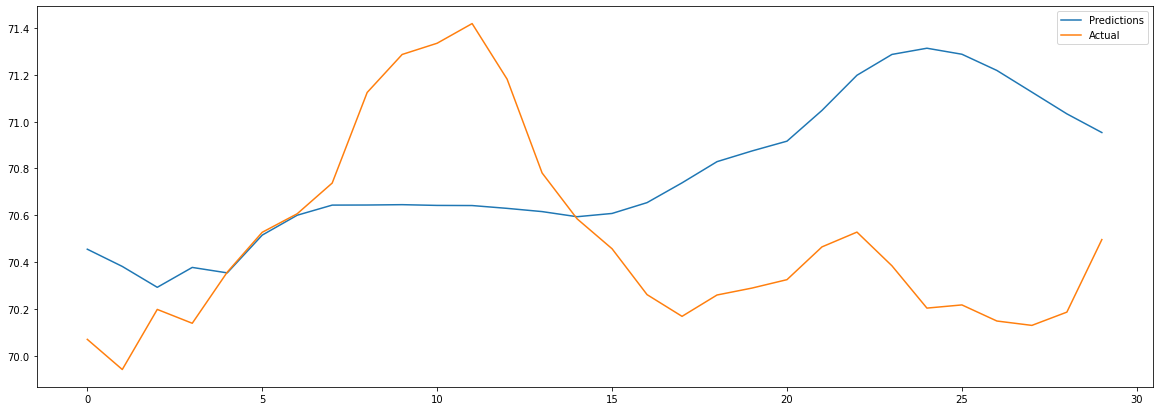

In [86]:
# first example for 5 minutes
plt.figure(figsize=(20,7))
plt.plot(unscale_data(preds[1003], float(avg), float(std)))
plt.plot(Y_test[:,:,0][1003])
plt.legend(['Predictions', 'Actual'], loc='upper right')

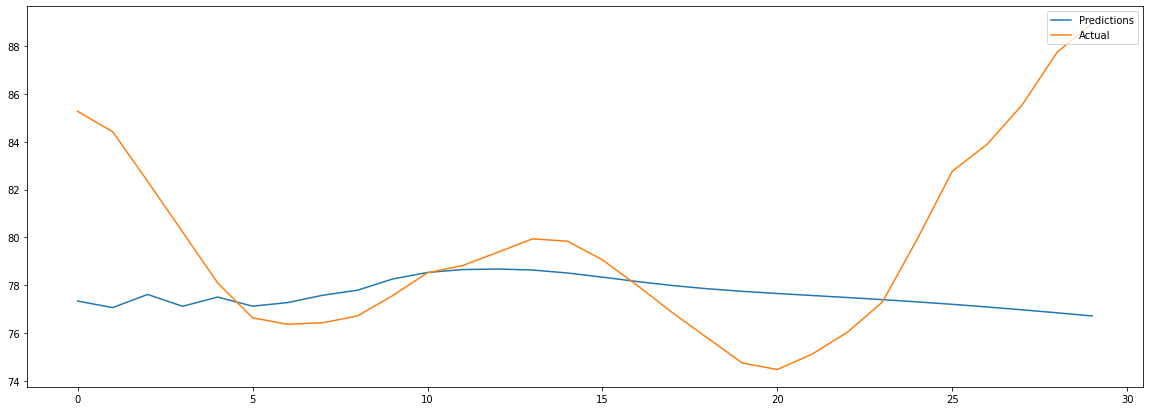

In [92]:
# second example for 5 minutes
plt.figure(figsize=(20,7))
plt.plot(unscale_data(preds[3705], float(avg), float(std)))
plt.plot(Y_test[:,:,0][3705])
plt.legend(['Predictions', 'Actual'], loc='upper right')

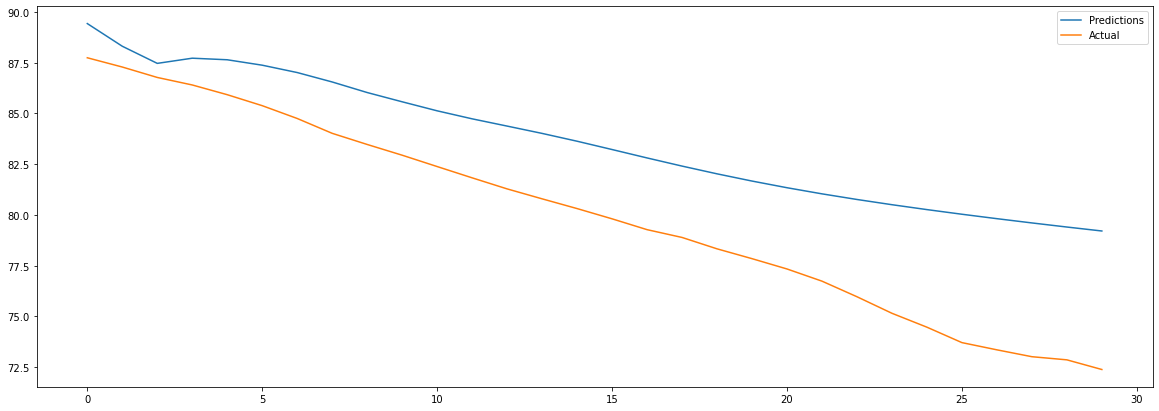

In [101]:
# third example for 5 minutes
plt.figure(figsize=(20,7))
plt.plot(unscale_data(preds[690], float(avg), float(std)))
plt.plot(Y_test[:,:,0][690])
plt.legend(['Predictions', 'Actual'], loc='upper right')

In [93]:
# plt.figure(figsize=(20,7))
# plt.plot(preds[0])
# plt.plot(Y_test[:,:,0][0])
# plt.legend(['Predictions', 'Actual'], loc='upper right')

In [31]:
# torch.save({
#             'learning_rate': learning_rate,
#             'dropout_rate': dropout_rate,
#             'num_layers':num_layers,
#             'hidden_dim': hidden_dim,
#             'model_state_dict': model.state_dict(),
#             'loss': loss,
#             'min_valid_loss': min_valid_loss,
#             'preds':preds,
# #             'test_preds': test_preds,
#             },r"C:\Users\rmartinez4\Box\Personal Git\dse-capstone\seq2seq_example\aop_at_10min.pt")

Train: ids, Test: ids, Test RMSE: 0.280350


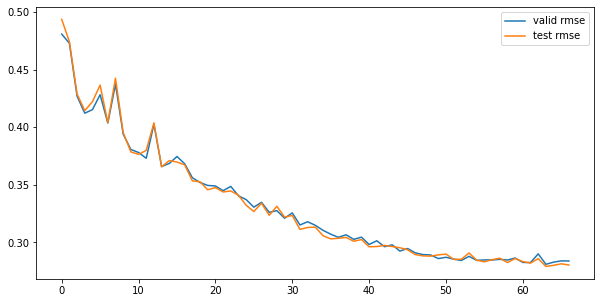

In [18]:
train_rmse, valid_rmse = loss
plt.figure(figsize=(10,5))
plt.plot(valid_rmse)
plt.plot(test_rmse)
plt.legend(['valid rmse', 'test rmse'], loc='upper right')
print('Train: %s, Test: %s, Test RMSE: %f' % (TREND, TEST_TREND, test_rmse[-1]) )

In [59]:

# def scale_with_avg_std(data_x, data_y, avg, std, c_avg, c_std):
#     data_x[:,:,0] = (data_x[:,:,0] - avg)/std
#     data_x[:,:,1] = (data_x[:,:,1] - c_avg)/c_std
#     data_y = (data_y-avg)/std
#     return data_x, data_y

# t_rmse_trend_dict = {}
# def test_trend(trend):
#     X_test_trend = torch.load(os.path.abspath('../data/data/at_test_10min/%s_x_test' % trend))[test_input_size-test_size: test_input_size]
#     Y_test_trend = torch.load(os.path.abspath('../data/data/at_test_10min/%s_y_test' % trend))[test_input_size-test_size: test_input_size]
#     X_test_trend, Y_test_trend = scale_with_avg_std(X_test_trend, Y_test_trend, avg, std, c_avg, c_std)
#     test_trend_size = Y_test_trend.shape[0]
#     criterion = nn.MSELoss()
#     test_rmse, test_set = [], Dataset(X_test_trend, Y_test_trend, np.array(range(test_trend_size)), output_steps)
#     test_generator = data.DataLoader(test_set, batch_size = 64, shuffle = False)
#     t_rmse_trend, test_predictions_trend = run_epoch_eval(model, test_generator, criterion, return_pred = True)
#     t_rmse_trend_dict[trend] = t_rmse_trend
    
# for trend in ['i', 'd', 's']:
#     test_trend(trend)
# print('Train: %s, test rmse: %s' % (TREND, t_rmse_trend_dict))